In [1]:
import pandas as pd
import numpy as np
import os
import sys
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from functools import  partial
parent_dir = os.path.dirname(os.environ["GTE_DIR"].replace("Glaciation_time_estimator",""))
GTE_DIR=os.environ["GTE_DIR"]
sys.path.insert(0, parent_dir)
from Glaciation_time_estimator.Data_postprocessing.Job_result_fp_generator import generate_tracking_filenames
from Glaciation_time_estimator.Auxiliary_func.config_reader import read_config


In [2]:
from derivative import dxdt
from scipy.integrate import cumulative_trapezoid

Load data

In [3]:
config = read_config(
    os.path.join(GTE_DIR,'config_half.yaml'))
analyze_year=True
year=2022

In [4]:
global global_rmse
global_rmse = config["Global_sqrt_mse"]

In [5]:
def Extract_array_from_df(series: pd.Series):
    if series.empty:
        return None
    return np.stack(series.values)


class Peak:
    def __init__(self, startidx):
        self.born = self.left = self.right = startidx
        self.died = None

    def get_persistence(self, seq):
        return float("inf") if self.died is None else seq[self.born] - seq[self.died]


def get_persistent_homology(seq):
    peaks = []
    # Maps indices to peaks
    idxtopeak = [None for s in seq]
    # Sequence indices sorted by values
    indices = range(len(seq))
    indices = sorted(indices, key=lambda i: seq[i], reverse=True)

    # Process each sample in descending order
    for idx in indices:
        lftdone = (idx > 0 and idxtopeak[idx-1] is not None)
        rgtdone = (idx < len(seq)-1 and idxtopeak[idx+1] is not None)
        il = idxtopeak[idx-1] if lftdone else None
        ir = idxtopeak[idx+1] if rgtdone else None

        # New peak born
        if not lftdone and not rgtdone:
            peaks.append(Peak(idx))
            idxtopeak[idx] = len(peaks)-1

        # Directly merge to next peak left
        if lftdone and not rgtdone:
            peaks[il].right += 1
            idxtopeak[idx] = il

        # Directly merge to next peak right
        if not lftdone and rgtdone:
            peaks[ir].left -= 1
            idxtopeak[idx] = ir

        # Merge left and right peaks
        if lftdone and rgtdone:
            # Left was born earlier: merge right to left
            if seq[peaks[il].born] > seq[peaks[ir].born]:
                peaks[ir].died = idx
                peaks[il].right = peaks[ir].right
                idxtopeak[peaks[il].right] = idxtopeak[idx] = il
            else:
                peaks[il].died = idx
                peaks[ir].left = peaks[il].left
                idxtopeak[peaks[ir].left] = idxtopeak[idx] = ir

    # This is optional convenience
    # return sorted(peaks, key=lambda p: p.get_persistence(seq), reverse=True)
    # return idxtopeak, sorted(peaks, key=lambda p: -p.born, reverse=True)
    return peaks


class Glaciation:
    def __init__(self, min_ind, max_ind, data, timestep=15):
        self.max = data[max_ind]
        self.min = data[min_ind]
        self.min_ind = min_ind
        self.max_ind = max_ind
        self.magnitude = self.max - self.min
        self.time = (max_ind - min_ind)*timestep
        self.timestep=timestep
    def estimate_glac_time(self,data ,max_rmse_diff=2 ):
        glac_timesteps=self.max_ind- self.min_ind
        if glac_timesteps ==1:
            self.linear=True
            time=self.timestep
            self.rate_arr=np.array([(self.max-self.min)/self.timestep*60])
            self.line_rmse=0
        else:
            #Calculate mean suqared error relative to a line between the two points
            linear_growth_line = np.linspace(data[self.min_ind],data[self.max_ind], num =glac_timesteps+1 )
            rmse = np.sqrt((np.square(linear_growth_line - data[self.min_ind:self.max_ind+1])).mean())
            self.line_rmse=rmse
            if rmse>max_rmse_diff*global_rmse:
                self.linear=False
                #This divide by 3 is the magic number that makes all the noise robust derivatives work
                magical_factor=3
                t=np.arange(len(data))/magical_factor
                #TODO: Correct min and max ind to min and max in filtered data
                dIFdt = dxdt(data, t, kind="trend_filtered", order=0, alpha=1e-2)
                trend_filtered_curve = data[0] + cumulative_trapezoid(dIFdt, t, initial=0)
                # self.find_nearest_peak(trend_filtered_curve)
                #Correct so that total delta is equal to measured magnitude
                dIFdt_glac = dIFdt[self.min_ind:self.max_ind+1]
                dIFdt_glac *= self.magnitude/(cumulative_trapezoid(dIFdt_glac, t[self.min_ind:self.max_ind+1], initial=0)[-1])

                #Factor *4/3 added: 4 to convert to hours  and 3 to correct for the factor added above
                dIFdt_glac *= 60/self.timestep/magical_factor
                #Not sure about min rate to take
                self.rate_arr=dIFdt_glac[dIFdt_glac>1e-2]
                # print(f"rmse = {rmse:03f}: Non-linear")
            else:
                # print(f"rmse = {rmse:03f}: Linear")
                self.linear=True
                self.rate_arr=np.full(glac_timesteps , (self.max-self.min)/(glac_timesteps*self.timestep)*60)
        self.avg_rate = self.rate_arr.mean()


def select_peaks(data, filt, significant_peak_tresh=0.2, glac_tresh=0.4):
    if not isinstance(data, (list, np.ndarray)):
        data = data['ice_frac_hist']
    if filt is not None:
        filt_data = np.array(filt(data))
    else:
        filt_data = np.array(data)
    peaks = get_persistent_homology(filt_data)
    prev_peak = Peak(0)
    glac_list = []
    for peak in peaks:
        if peak.born > prev_peak.born+1:
            if peak.get_persistence(filt_data) >= significant_peak_tresh:
                # local_min = data[prev_peak.born:peak.born].min()
                # print(f"{prev_peak.born},{peak.born}")
                inter_peak_data = filt_data[prev_peak.born:peak.born]
                local_min_ind = np.where(
                    inter_peak_data == inter_peak_data.min())[0][-1]
                local_min = inter_peak_data[local_min_ind]
                if filt_data[peak.born] - local_min >= glac_tresh:
                    glac_list.append(Glaciation(
                        prev_peak.born + local_min_ind, peak.born, filt_data))
                    glac_list[-1].estimate_glac_time(filt_data)
                    # print("a")
                prev_peak = peak
    return glac_list


def get_combined_cloud_df(config):
    t_deltas = config['t_deltas']
    agg_fact = config['agg_fact']
    min_temp_array, max_temp_array = config['min_temp_arr'], config['max_temp_arr']
    folder_name = f"{config['start_time'].strftime(config['time_folder_format'])}_{config['end_time'].strftime(config['time_folder_format'])}"
    # Initialize an empty list to store the individual dataframes
    cloud_properties_df_list = []

    # Iterate over each temperature range
    for i in range(len(min_temp_array)):
        cloud_properties_df_list.append([])
        min_temp = min_temp_array[i]
        max_temp = max_temp_array[i]

        # Iterate over each pole
        for pole in config["pole_folders"]:
            # Construct the file path
            fp = os.path.join(
                config['postprocessing_output_dir'],
                pole,
                folder_name,
                f"Agg_{agg_fact:02}_T_{abs(round(min_temp)):02}_{abs(round(max_temp)):02}.parquet"
            )

            # Read the parquet file into a dataframe
            df = pd.read_parquet(fp)

            # Add columns for min_temp, max_temp, and pole
            df['min_temp'] = min_temp
            df['max_temp'] = max_temp
            df['pole'] = pole
            df['Hemisphere'] = "South" if pole == "sp" else "North"
            df['Lifetime [h]'] = df['track_length'] / pd.Timedelta(hours=1)
            df["Radius [km]"]=np.sqrt(df["avg_size[km]"]/np.pi)
            # Append the dataframe to the sublist
            cloud_properties_df_list[i].append(df)

    # Combine all dataframes into a single dataframe
    return pd.concat(
        [df for sublist in cloud_properties_df_list for df in sublist], ignore_index=True)


def extract_glaciation_events(df):
    out_df = df[df["max_ice_fraction"]-(1-df["max_water_frac"]) > 0.5].copy()
    part_select_peaks = partial(select_peaks, filt=None)
    out_df["glac_list"] = df.apply(part_select_peaks, axis=1)
    return out_df


def gen_glac_df(result_df, combined_cloud_df):
    glaciations_list = []
    for i, row in result_df.iterrows():
        for glaciation in row['glac_list']:
            # glaciation.
            glaciations_list.append([i, glaciation.time, glaciation.magnitude, glaciation.min_ind , glaciation.max_ind, glaciation.linear, glaciation.line_rmse, glaciation.rate_arr,glaciation.rate_arr.mean() ])
    glaciations_df = pd.DataFrame(glaciations_list, columns=[
        "Cloud_ID", "Time [m]", "Magnitude", "Glac_start_ind", "Glac_peak_ind", "Linear", "line_rmse", "Rate_arr", "Mean_glac_rate"])
    glaciations_df["Glaciation time [h]"] = glaciations_df["Time [m]"]/60
    return pd.merge(glaciations_df, combined_cloud_df, how="left",
                    left_on="Cloud_ID", right_index=True, validate="m:1")


def save_glac_df(glaciations_df, config):
    for pole in config["pole_folders"]:
        output_dir = os.path.join(
            config['postprocessing_output_dir'], pole,
            config['time_folder_name'],
            f"Agg_{config['agg_fact']:02}_Glaciations"
        )
        # Save DataFrame to Parquet
        output_dir_parq = output_dir + ".parquet"
        print("Writing to ", output_dir_parq)
        glaciations_df.to_parquet(output_dir_parq)

        # Optionally save as CSV
        if config['write_csv']:
            output_dir_csv = output_dir + ".csv"
            glaciations_df.to_csv(output_dir_csv)



In [6]:
#combined_cloud_df = get_combined_cloud_df(config)
# result_df = extract_glaciation_events(combined_cloud_df)
# for i, row in result_df.iloc[:50].iterrows():
#     for glac in row.glac_list:
#         glac.estimate_glac_time(np.array(row["ice_frac_hist"]))
# glaciations_df = gen_glac_df(result_df, combined_cloud_df)
# save_glac_df(glaciations_df, config)

In [7]:
# output_dir = os.path.join(
#     config['postprocessing_output_dir'], "np",
#     config['time_folder_name'],
#     f"Agg_{config['agg_fact']:02}_Glaciations"
# )

# # Save DataFrame to Parquet
# output_dir_parq = output_dir + ".parquet"
# if os.path.isfile(output_dir_parq):
#     print("Glaciations file exists")
#     combined_cloud_df = get_combined_cloud_df(config)
#     glaciations_df = pd.read_parquet(output_dir_parq)
#     glaciating_clouds = glaciations_df.drop_duplicates(subset="Cloud_ID",keep="first")
# else:
#     print("Glaciations file desn't exist")
#     sqrt_mse = config["Global_sqrt_mse"]
#     combined_cloud_df = get_combined_cloud_df(config)
#     result_df = extract_glaciation_events(combined_cloud_df)
#     glaciations_df = gen_glac_df(result_df, combined_cloud_df)
#     save_glac_df(glaciations_df, config)
#     glaciating_clouds = glaciations_df.drop_duplicates(subset="Cloud_ID",keep="first")

In [8]:
if os.uname()[1]=="n2o":
    combined_cloud_df = pd.read_parquet("/wolke_scratch/dnikolo/Final_results/2022_all.parquet")
    glaciations_df = pd.read_parquet("/wolke_scratch/dnikolo/Final_results/2022_glac.parquet")
    glaciations_df["Radius [km]"]=np.sqrt(glaciations_df["avg_size[km]"]/np.pi)
    glaciating_clouds = glaciations_df.drop_duplicates(subset="Cloud_ID",keep="first")

In [9]:
ice_cont_crit_frac = 0.05

Load data

In [10]:
sample_df_3 = combined_cloud_df.sample(1000, random_state=2)
sample_df_3 = sample_df_3[sample_df_3["max_ice_fraction"]-(1-sample_df_3["max_water_frac"])>0.9]

/wolke_scratch/dnikolo/flex_trkr_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_3738/219524483.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


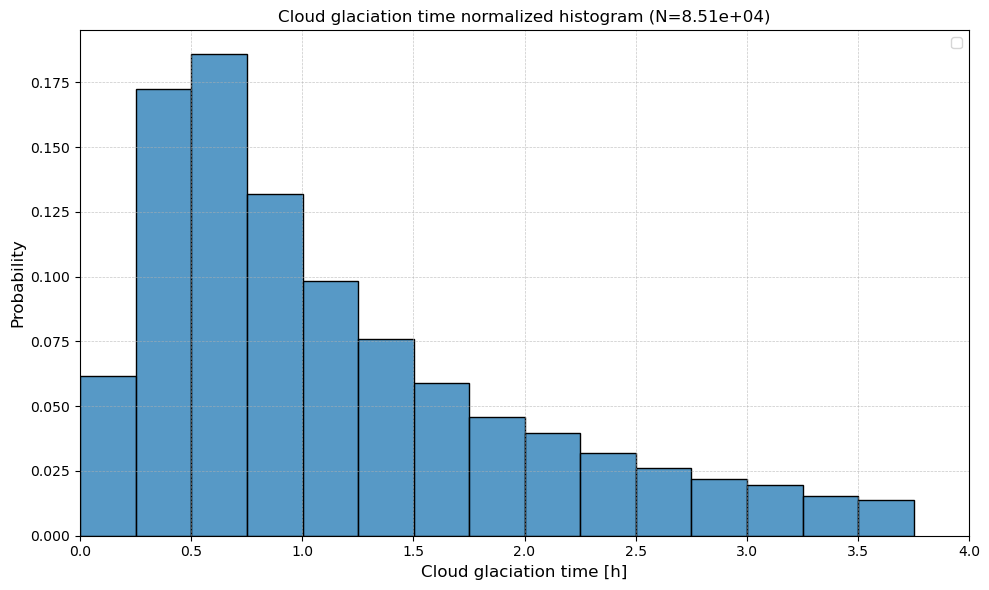

In [11]:
bins=np.arange(0,4,0.25)+0.001
f, ax = plt.subplots(figsize=(10, 6))  # Increased figure size for better readability
sns.histplot(data=glaciations_df, x="Glaciation time [h]",bins=bins,stat="probability",)
plt.ylabel("Cloud number")
ax.set_xlabel("Cloud glaciation time [h]", fontsize=12)
ax.set_ylabel("Probability", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()

plt.title(f"Cloud glaciation time normalized histogram (N={len(glaciations_df):.2e})")
plt.xlim(0,4)
plt.tight_layout()
plt.savefig(os.path.join(GTE_DIR,"Result_graphs/CGT_stistics.png"),dpi=400)

/wolke_scratch/dnikolo/flex_trkr_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/wolke_scratch/dnikolo/flex_trkr_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/wolke_scratch/dnikolo/flex_trkr_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/wolke_scratch/dnikolo/flex_trkr_env/li

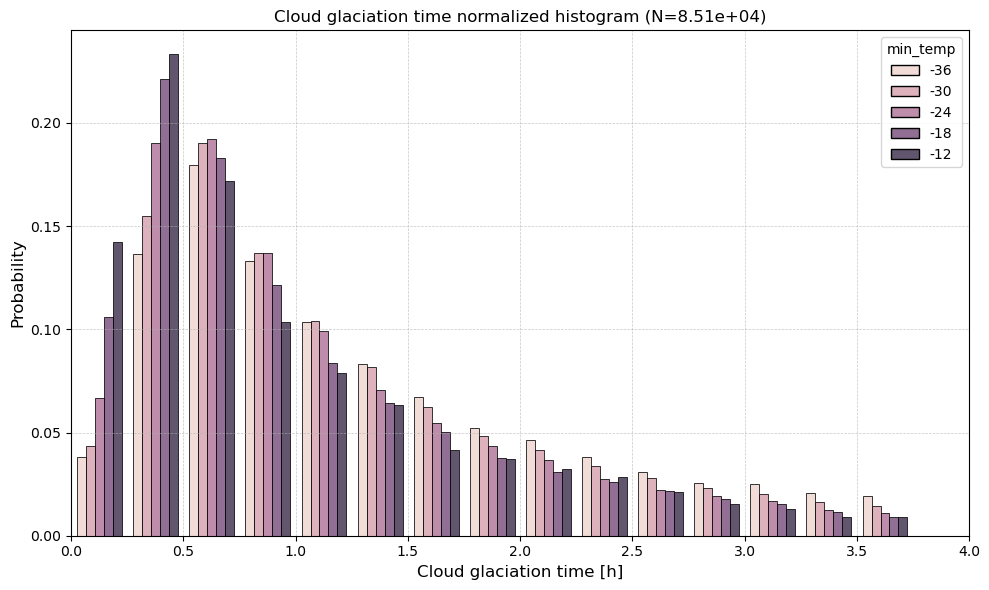

In [12]:
bins=np.arange(0,4,0.25)+0.001
f, ax = plt.subplots(figsize=(10, 6))  # Increased figure size for better readability
sns.histplot(data=glaciations_df, x="Glaciation time [h]",multiple="dodge", hue='min_temp',common_norm=False,bins=bins,stat="probability",shrink=0.8)
plt.ylabel("Cloud number")
ax.set_xlabel("Cloud glaciation time [h]", fontsize=12)
ax.set_ylabel("Probability", fontsize=12)
# ax.legend(fontsize=10)
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# plt.tight_layout()
# plt.legend()
plt.title(f"Cloud glaciation time normalized histogram (N={len(glaciations_df):.2e})")
plt.xlim(0,4)
plt.tight_layout()
plt.savefig(os.path.join(GTE_DIR,"Result_graphs/CGT_stistics.png"),dpi=400)

/wolke_scratch/dnikolo/flex_trkr_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/wolke_scratch/dnikolo/flex_trkr_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/wolke_scratch/dnikolo/flex_trkr_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/wolke_scratch/dnikolo/flex_trkr_env/li

<Axes: xlabel='Glaciation time [h]', ylabel='Probability'>

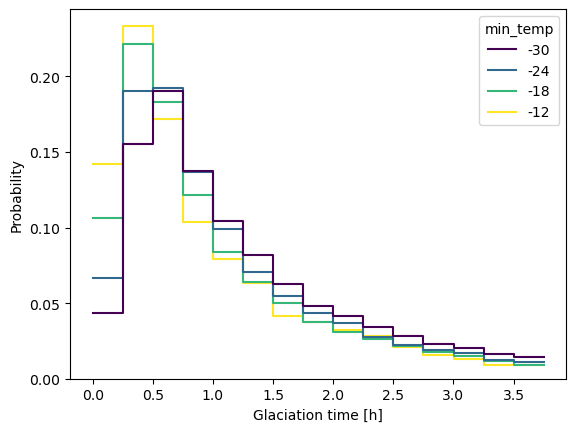

In [13]:
sns.histplot(data=glaciations_df[glaciations_df["min_temp"]>=-30], x="Glaciation time [h]",element="step",fill=False, hue='min_temp',common_norm=False,bins=bins,stat="probability",palette="viridis")

In [14]:
glaciations_df.min_temp

0       -12
1       -12
2       -12
3       -12
4       -12
         ..
85111   -36
85112   -36
85113   -36
85114   -36
85115   -36
Name: min_temp, Length: 85116, dtype: int64

/wolke_scratch/dnikolo/flex_trkr_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/wolke_scratch/dnikolo/flex_trkr_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


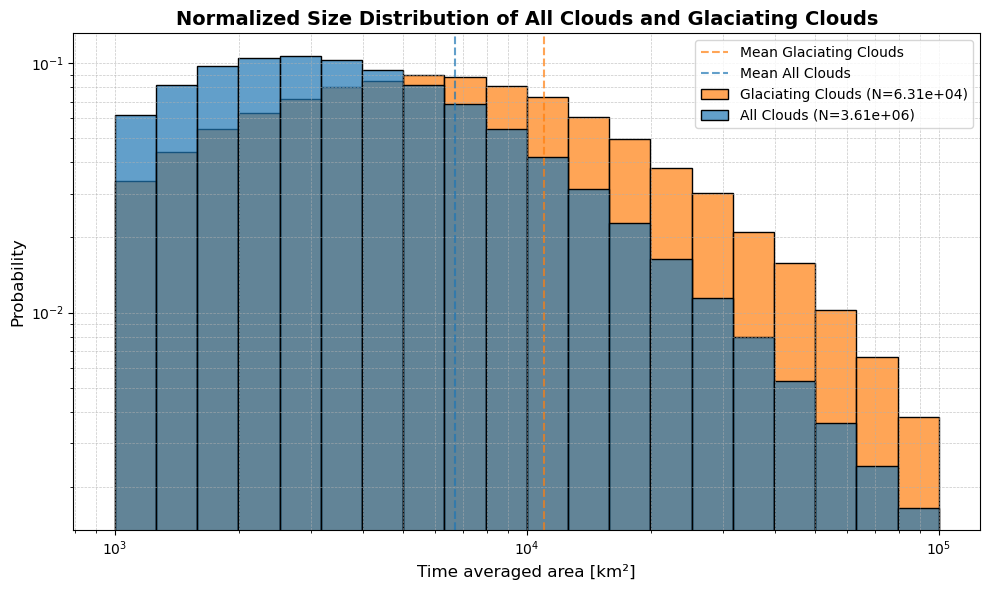

In [15]:

# Assuming `glaciating_clouds` and `combined_cloud_df` are preloaded DataFrames
mean_glaciating = glaciating_clouds['avg_size[km]'].mean()
mean_combined = combined_cloud_df['avg_size[km]'].mean()

f, ax = plt.subplots(figsize=(10, 6))  # Increased figure size for better readability

# Plot histograms
sns.histplot(
    data=glaciating_clouds,
    ax=ax,
    x="avg_size[km]",
    log_scale=(True, False),
    binrange=(3, 5),
    bins=20,
    color=sns.color_palette()[1],
    stat="probability",
    label=f"Glaciating Clouds (N={len(glaciating_clouds):.2e})",
    alpha=0.7  # Slight transparency for overlap visibility
)

sns.histplot(
    data=combined_cloud_df,
    ax=ax,
    x="avg_size[km]",
    log_scale=(True, False),
    binrange=(3, 5),
    bins=20,
    color=sns.color_palette()[0],
    stat="probability",
    label=f"All Clouds (N={len(combined_cloud_df):.2e})",
    alpha=0.7
)

# Add vertical lines for means
ax.axvline(mean_glaciating, linestyle="--", color=sns.color_palette()[1], linewidth=1.5, alpha=0.7, label="Mean Glaciating Clouds")
ax.axvline(mean_combined, color=sns.color_palette()[0], linestyle="--", linewidth=1.5, alpha=0.7, label="Mean All Clouds")

# Set logarithmic y-axis
ax.set_yscale("log")

# Beautify the plot
ax.set_title("Normalized Size Distribution of All Clouds and Glaciating Clouds", fontsize=14, weight="bold")
ax.set_xlabel("Time averaged area [km²]", fontsize=12)
ax.set_ylabel("Probability", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()

# Save the figure
filename = os.path.join(GTE_DIR,"Result_graphs/Size_hist_all_vs_glac_normalized")
plt.savefig(filename + ".pdf", dpi=400)
plt.savefig(filename + ".png", dpi=400)

/wolke_scratch/dnikolo/flex_trkr_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/wolke_scratch/dnikolo/flex_trkr_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/wolke_scratch/dnikolo/flex_trkr_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/wolke_scratch/dnikolo/flex_trkr_env/li

Text(0.5, 1.0, 'Distribution of glaciation magnitudes ')

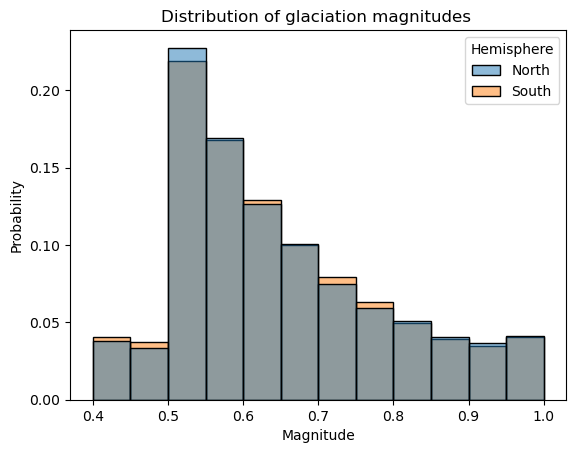

In [16]:
sns.histplot(glaciations_df,x="Magnitude",binwidth=0.05,stat="probability",hue="Hemisphere", common_norm=False)
plt.title("Distribution of glaciation magnitudes ")

In [17]:
# sns.histplot(glaciations_df[glaciations_df["Hemisphere"]=="South"]["Magnitude"],binwidth=0.05, stat="probability",hu)
# sns.histplot(glaciations_df[glaciations_df["Hemisphere"]=="North"]["Magnitude"],binwidth=0.05, stat="probability")
# plt.title("Distribution of glacaition magnitude w")

/wolke_scratch/dnikolo/flex_trkr_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/wolke_scratch/dnikolo/flex_trkr_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/wolke_scratch/dnikolo/flex_trkr_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/wolke_scratch/dnikolo/flex_trkr_env/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


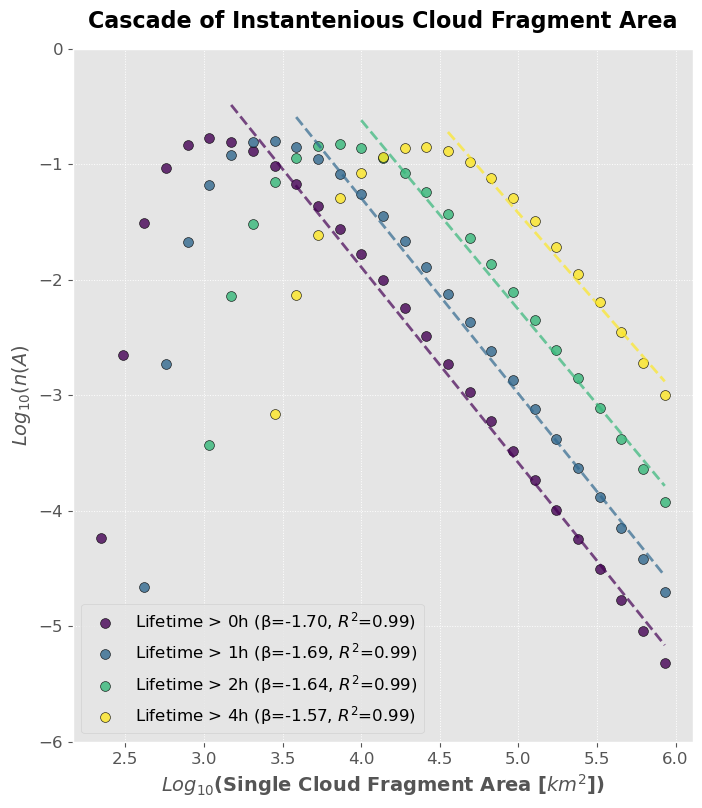

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# Use a modern style
plt.style.use("ggplot")

# Define the exponents and bins
exponents = np.linspace(2, 6, 30)
centers = exponents[:-1] + (exponents[1:] - exponents[:-1]) / 2
bins = np.power(10, exponents)
bin_width=bins[1:]-bins[:-1]
lifetime_thresholds = [0 ,1, 2, 4]

# Set up figure
fig, ax = plt.subplots(figsize=(8, 9))

# Use a colormap for better differentiation
colors = plt.cm.viridis(np.linspace(0, 1, len(lifetime_thresholds)))

for i, lifetime_thresh in enumerate(lifetime_thresholds):
    # Normalize cloud area
    combined_cloud_df["norm_area"] = combined_cloud_df["avg_size[km]"] * combined_cloud_df["Lifetime [h]"]

    # Bin data
    bin_counts = pd.cut(
        combined_cloud_df[ (combined_cloud_df["Lifetime [h]"] > lifetime_thresh)]["norm_area"], bins
    ).value_counts(sort=False)/bin_width#*3000*800/((3000-np.power(10,centers/2)/18-1)*(800-np.power(10,centers/2)/18-1))
    
    # Normalize bin counts
    new_df = pd.DataFrame({"bin_counts": bin_counts, "center": centers})
    new_df["bin_counts"] = new_df["bin_counts"] / new_df["bin_counts"].sum()
    
    # Fit line to the tail of the distribution
    fit_df = new_df[new_df["bin_counts"].idxmax():].iloc[1:]
    coef = np.polyfit(x=fit_df["center"], y=np.log10(fit_df["bin_counts"]), deg=1)
    poly1d_fn = np.poly1d(coef)
    
    # # Scatter plot with better markers
    # ax.scatter(new_df["center"], np.log10(new_df["bin_counts"]), label=f'Lifetime > {lifetime_thresh}h (β={coef[0]:.02f})', 
    #            color=colors[i], s=50, alpha=0.8, edgecolors="black")
    R2 = r2_score(np.log10(fit_df["bin_counts"]), poly1d_fn(fit_df["center"]))
    # Scatter plot with better markers
    ax.scatter(new_df["center"], np.log10(new_df["bin_counts"]), label=f'Lifetime > {lifetime_thresh}h (β={coef[0]:.02f}, $R^2$={R2:.02f})', 
               color=colors[i], s=50, alpha=0.8, edgecolors="black")
    # Fitted line with better visibility
    ax.plot(fit_df["center"], poly1d_fn(fit_df["center"]), linestyle="--", linewidth=2, alpha=0.7, color=colors[i])

# Improve axes formatting
# ax.set_xscale("log")
ax.set_ylim(-6,0)
ax.set_xlabel("$Log_{10}$(Single Cloud Fragment Area [$km^2$])", fontsize=14, fontweight='bold')
ax.set_ylabel("$Log_{10}(n(A)$", fontsize=14, fontweight='bold')
ax.legend(fontsize=12, loc="lower left")
ax.set_title("Cascade of Instantenious Cloud Fragment Area", fontsize=16, fontweight='bold', pad=15)
# Add grid with minor ticks
ax.grid(True, which="both", linestyle=":", linewidth=0.7)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.savefig(os.path.join(GTE_DIR,"Result_graphs/Avg_area_log_scale_cascade.png"),dpi=400)
# Show plot
plt.show()

In [19]:
combined_cloud_df["Cloud type"].value_counts()

Cloud type
Altostratus        556427
Nimbostratus       343001
Stratocumulus      224502
Altocumulus        167067
Cirrostratus       157932
Deep convection    131092
Cumulus             76165
Stratus             43628
Cirrus              35456
Name: count, dtype: int64

/wolke_scratch/dnikolo/flex_trkr_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


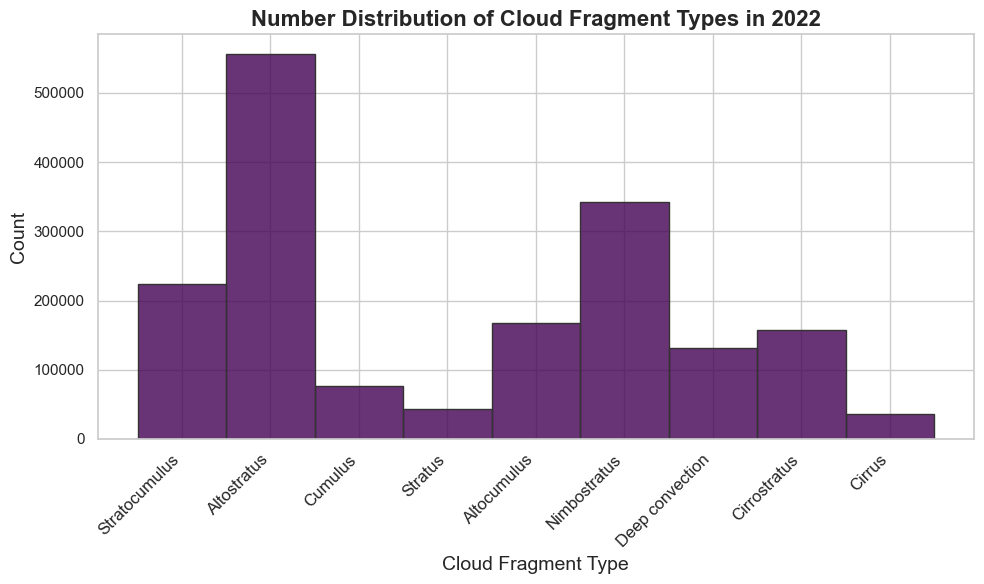

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the overall theme and style
sns.set_theme(style="whitegrid")

# Increase figure size for better clarity
plt.figure(figsize=(10, 6))

# Create the histogram with a pastel palette and subtle edge colors
ax = sns.histplot(
    data=combined_cloud_df,
    x="Cloud type",
    color=colors[0],      # You can customize the color as desired
    edgecolor=".2",        # Adds a slight border for clarity
    alpha=0.8
)

# Customize title and axis labels
ax.set_title("Number Distribution of Cloud Fragment Types in 2022", fontsize=16, fontweight='bold')
ax.set_xlabel("Cloud Fragment Type", fontsize=14)
ax.set_ylabel("Count", fontsize=14)

# Adjust x-ticks: rotate, adjust font size, and align to the left
plt.xticks(fontsize=12, rotation=45, ha='right')

# Improve layout spacing
plt.tight_layout()
plt.savefig(os.path.join(GTE_DIR, "Result_graphs/Type_number_distribution.png"),dpi=400)


<Figure size 1000x600 with 0 Axes>

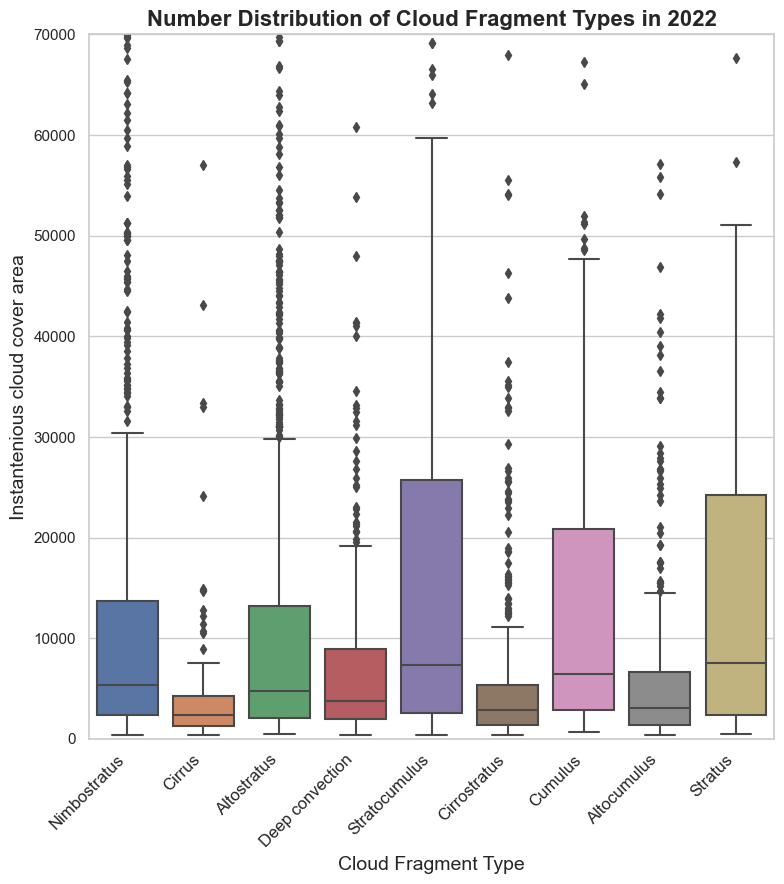

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the overall theme and style
sns.set_theme(style="whitegrid")

# Increase figure size for better clarity
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(figsize=(8, 9))
# Create the histogram with a pastel palette and subtle edge colors

# ax = sns.barplot(
#     x = combined_cloud_df.groupby("Cloud type")["norm_area"].sum().index,
#     y = combined_cloud_df.groupby("Cloud type")["norm_area"].sum(),
#     color=colors[0],      # You can customize the color as desired
#     edgecolor=".2"        # Adds a slight border for clarity
# )
combined_cloud_df["norm_area"] = combined_cloud_df["avg_size[km]"] * combined_cloud_df["Lifetime [h]"]
sns.boxplot(data=combined_cloud_df.sample(10000),ax=ax, x="Cloud type", y="norm_area")

# Customize title and axis labels
ax.set_title("Number Distribution of Cloud Fragment Types in 2022", fontsize=16, fontweight='bold')
ax.set_xlabel("Cloud Fragment Type", fontsize=14)
ax.set_ylabel("Instantenious cloud cover area", fontsize=14)
ax.set_ylim(0,0.7e5)
# Adjust x-ticks: rotate, adjust font size, and align to the left
plt.xticks(fontsize=12, rotation=45, ha='right')

# Improve layout spacing
plt.tight_layout()
# plt.savefig(os.path.join(GTE_DIR, "Type_area_distribution.png"),dpi=400)

<Figure size 1000x600 with 0 Axes>

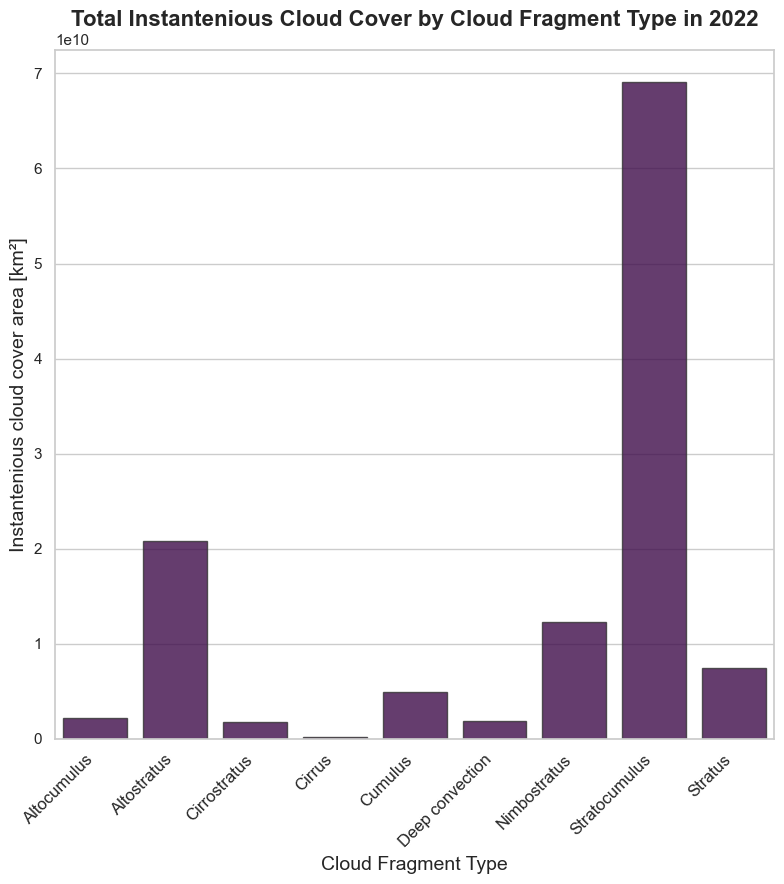

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the overall theme and style
sns.set_theme(style="whitegrid")

# Increase figure size for better clarity
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(figsize=(8, 9))
# Create the histogram with a pastel palette and subtle edge colors
total_area_per_clloud_type=combined_cloud_df.groupby("Cloud type")["norm_area"].sum()
total_area_per_clloud_type=total_area_per_clloud_type
ax = sns.barplot(
    x = total_area_per_clloud_type.index,
    y = total_area_per_clloud_type,
    color=colors[0],      # You can customize the color as desired
    edgecolor=".2",        # Adds a slight border for clarity
    alpha=0.8
)
# ax.bar_label(ax.containers[0], fontsize=10)
# Customize title and axis labels
ax.set_title("Total Instantenious Cloud Cover by Cloud Fragment Type in 2022", fontsize=16, fontweight='bold')
ax.set_xlabel("Cloud Fragment Type", fontsize=14)
ax.set_ylabel(u"Instantenious cloud cover area [km²]", fontsize=14)
# ax.set_ylim(0,0.7e5)
# Adjust x-ticks: rotate, adjust font size, and align to the left
plt.xticks(fontsize=12, rotation=45, ha='right')

# Improve layout spacing
plt.tight_layout()
plt.savefig(os.path.join(GTE_DIR, "Result_graphs/Type_area_distribution.png"),dpi=400)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

exponents = np.linspace(1, 3, 20)
centers = exponents[:-1] + (exponents[1:] - exponents[:-1]) / 2
bins = np.power(10, exponents)
bin_width=bins[1:]-bins[:-1]
lifetime_thresholds = [0, 1, 2, 4]

# Set up figure
fig, ax = plt.subplots(figsize=(8, 9))

# Use a colormap for better differentiation
colors = plt.cm.viridis(np.linspace(0, 1, len(lifetime_thresholds)))

for i, lifetime_thresh in enumerate(lifetime_thresholds):
    # Normalize cloud radius
    combined_cloud_df["norm_radius"] = combined_cloud_df["Radius [km]"] * combined_cloud_df["Lifetime [h]"]

    # Bin data
    bin_counts = pd.cut(
        combined_cloud_df[ (combined_cloud_df["Cloud type"]=="Altostratus" ) & (combined_cloud_df["Cloud type"]!="" )&(combined_cloud_df["Lifetime [h]"] > lifetime_thresh)
        ]["norm_radius"], bins
    ).value_counts(sort=False)/bin_width
    
    # Normalize bin counts
    new_df = pd.DataFrame({"bin_counts": bin_counts, "center": centers})
    new_df["bin_counts"] = new_df["bin_counts"] / new_df["bin_counts"].sum()

    # Fit line to the tail of the distribution
    fit_df = new_df[new_df["bin_counts"].idxmax():].iloc[3:]
    coef = np.polyfit(x=fit_df["center"], y=np.log10(fit_df["bin_counts"]), deg=1)
    poly1d_fn = np.poly1d(coef)
    R2 = r2_score(np.log10(fit_df["bin_counts"]), poly1d_fn(fit_df["center"]))
    # Scatter plot with better markers
    ax.scatter(new_df["center"], np.log10(new_df["bin_counts"]), label=f'Lifetime > {lifetime_thresh}h (β={coef[0]:.02f}, $R^2$={R2:.02f})', 
               color=colors[i], s=50, alpha=0.8, edgecolors="black")
    
    # Fitted line with better visibility
    ax.plot(fit_df["center"], poly1d_fn(fit_df["center"]), linestyle="--", linewidth=2, alpha=0.7, color=colors[i])

# Improve axes formatting
# ax.set_xscale("log")
# ax.set_ylim(-7,-2)
ax.set_title("Cascade of Instantenious Cloud Chord Length", fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel("$Log_{10}(Single Cloud Fragment Chord Length [km]$)", fontsize=14, fontweight='bold')
ax.set_ylabel("$Log_{10}(n(x))$", fontsize=14, fontweight='bold')
ax.legend(fontsize=12, loc="lower left")

# Add grid with minor ticks
ax.grid(True, which="both", linestyle=":", linewidth=0.7)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.savefig(os.path.join(GTE_DIR,"Result_graphs/Chord_length_log_scale_cascade.png"),dpi=400)
# Show plot
plt.show()


In [ ]:
combined_cloud_df["Radius [km]"].corr(combined_cloud_df["Lifetime [h]"])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

exponents = np.linspace(1, 4, 20)
centers = exponents[:-1] + (exponents[1:] - exponents[:-1]) / 2
bins = np.power(10, exponents)
bin_width=bins[1:]-bins[:-1]
lifetime_thresholds = [0, 1, 2, 4]

# Set up figure
fig, ax = plt.subplots(figsize=(8, 9))

# Use a colormap for better differentiation
colors = plt.cm.viridis(np.linspace(0, 1, len(lifetime_thresholds)))

for i, lifetime_thresh in enumerate(lifetime_thresholds):
    # Normalize cloud radius
    combined_cloud_df["norm_radius"] = combined_cloud_df["Radius [km]"] * combined_cloud_df["Lifetime [h]"]*np.pi/4

    # Bin data
    bin_counts = pd.cut(
        combined_cloud_df[(combined_cloud_df["Cloud type"]=="Stratocumulus") & (combined_cloud_df["Lifetime [h]"] > lifetime_thresh)
        ]["norm_radius"], bins
    ).value_counts(sort=False)/bin_width
    
    # Normalize bin counts
    new_df = pd.DataFrame({"bin_counts": bin_counts, "center": centers})
    new_df["bin_counts"] = new_df["bin_counts"] / new_df["bin_counts"].sum()

    # Fit line to the tail of the distribution
    fit_df = new_df[new_df["bin_counts"].idxmax():].iloc[1:]
    coef = np.polyfit(x=fit_df["center"], y=np.log10(fit_df["bin_counts"]), deg=1)
    poly1d_fn = np.poly1d(coef)
    R2 = r2_score(np.log10(fit_df["bin_counts"]), poly1d_fn(fit_df["center"]))
    # Scatter plot with better markers
    ax.scatter(new_df["center"], np.log10(new_df["bin_counts"]), label=f'Lifetime > {lifetime_thresh}h (β={coef[0]:.02f}, $R^2$={R2:.02f})', 
               color=colors[i], s=50, alpha=0.8, edgecolors="black")
    
    # Fitted line with better visibility
    ax.plot(fit_df["center"], poly1d_fn(fit_df["center"]), linestyle="--", linewidth=2, alpha=0.7, color=colors[i])

# Improve axes formatting
# ax.set_xscale("log")
# ax.set_ylim(-7,-2)
ax.set_title("Cascade of Time Normalized Cloud Chord Length", fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel("Log(Single Cloud Chord Length [$km$])", fontsize=14, fontweight='bold')
ax.set_ylabel("Log(Time normalized cloud count)", fontsize=14, fontweight='bold')
ax.legend(fontsize=12, loc="lower left")

# Add grid with minor ticks
ax.grid(True, which="both", linestyle=":", linewidth=0.7)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.savefig(os.path.join(GTE_DIR,"Result_graphs/Statocumulus_chord_length_log_scale_cascade.png"),dpi=400)
# Show plot
plt.show()

In [ ]:
count=0
for i,row_small in new_df[-1::-1].iterrows():
    print(i)
    for i,row_large in new_df.loc[i:].iterrows():
        new_df.loc[i, "bin_counts"]-=(np.power(10,row_large["center"])/np.power(10,row_small["center"])**2)*row_large["bin_counts"]
    

In [ ]:
bin_width
bin_counts/1000

In [ ]:
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

exponents = np.linspace(1, 4, 20)
centers = exponents[:-1] + (exponents[1:] - exponents[:-1]) / 2
bins = np.power(10, exponents)
bin_width = bins[1:] - bins[:-1]
lifetime_thresholds = [0,]

# Set up figure
fig, ax = plt.subplots(figsize=(8, 9))

# Use a colormap for better differentiation
colors = plt.cm.viridis(np.linspace(0, 1, len(lifetime_thresholds)))
# combined_cloud_df["norm_radius"] = combined_cloud_df["Radius [km]"] * combined_cloud_df["Lifetime [h]"]
# combined_cloud_df["Chord [km]"]=np.pi/4*combined_cloud_df["norm_radius"]
# sns.histplot(data=combined_cloud_df,x="Chord [km]", ax=ax, log_scale=[True,True], stat="density", bins=30)
for i, lifetime_thresh in enumerate(lifetime_thresholds):
    # Normalize cloud radius
    combined_cloud_df["norm_radius"] = combined_cloud_df["Radius [km]"] * combined_cloud_df["Lifetime [h]"]
    combined_cloud_df["Chord [km]"]=np.pi/4*combined_cloud_df["norm_radius"]
    combined_cloud_df["rad_bin"]= pd.cut(
            combined_cloud_df[(combined_cloud_df["Cloud type"]=="Stratocumulus") & (combined_cloud_df["Lifetime [h]"] > lifetime_thresh)
            ]["Chord [km]"], bins
        )
    
    # Bin data
    bin_counts = combined_cloud_df["rad_bin"].value_counts(sort=False)/bin_width#*combined_cloud_df[(combined_cloud_df["Cloud type"]=="Stratocumulus")].groupby("rad_bin")["Chord [km]"].sum()
    
    # Normalize bin counts
    new_df = pd.DataFrame({"bin_counts": bin_counts, "center": centers})
    new_df["bin_counts"] = new_df["bin_counts"] / new_df["bin_counts"].sum()
    count=0
    new_df_2=new_df.copy()
    # for p,row_small in new_df_2[-1::-1].iterrows():
    #     # print("p",p)
    #     count=0
    #     for j,row_large in new_df_2.loc[p:].iterrows():
    #         # print("j",j)
    #         if count!=0:
    #             # print((np.power(10,row_large["center"])/np.power(10,row_small["center"]))**2-1)
    #             ratio = np.power(10,row_large["center"])/np.power(10,row_small["center"])
    #             # print(ratio,row_large["center"],row_small["center"])
    #             if ratio>=10:
    #                 a=(ratio**2-1)*row_large["bin_counts"]
    #                 # print(a)
    #                 # if a/row_small["bin_counts"]>=0.05:
    #                 #     # print(a)
    #                 if a>0:
    #                     # new_df.loc[p, "bin_counts"]-=a
    #                     new_df.loc[j, "bin_counts"]+=a
    #                     # new_df.loc[j, "bin_counts"]+=a
    #                 # new_df.loc[j, "bin_counts"]+=a
    #         count+=1
    print(new_df)    
    # Fit line to the tail of the distribution
    fit_df = new_df[new_df["bin_counts"].idxmax():].iloc[1:]
    coef = np.polyfit(x=fit_df["center"], y=np.log10(fit_df["bin_counts"]), deg=1)
    poly1d_fn = np.poly1d(coef)
    R2 = r2_score(np.log10(fit_df["bin_counts"]), poly1d_fn(fit_df["center"]))
    # Scatter plot with better markers
    ax.scatter(new_df["center"], np.log10(new_df["bin_counts"]), label=f'Lifetime > {lifetime_thresh}h (β={coef[0]:.02f}, $R^2$={R2:.02f})', 
               color=colors[i], s=50, alpha=0.8, edgecolors="black")
    
    # Fitted line with better visibility
    ax.plot(fit_df["center"], poly1d_fn(fit_df["center"]), linestyle="--", linewidth=2, alpha=0.7, color=colors[i])

# Improve axes formatting
# ax.set_xscale("log")
# ax.set_ylim(-7,-2)
ax.set_title("Cascade of Time Normalized Cloud Chord Length", fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel("Log(Characteristic Chord Length [$km$])", fontsize=14, fontweight='bold')
ax.set_ylabel("Log(Time normalized cloud count)", fontsize=14, fontweight='bold')
ax.legend(fontsize=12, loc="lower left")

# Add grid with minor ticks
ax.grid(True, which="both", linestyle=":", linewidth=0.7)
ax.tick_params(axis='both', which='major', labelsize=12)
# plt.savefig(os.path.join(GTE_DIR,"Result_graphs/Chord_length_log_scale_cascade.png"),dpi=400)
# Show plot
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# (Assuming combined_cloud_df is already defined and populated)

# Compute the derived quantity
combined_cloud_df["norm_radius"] = combined_cloud_df["Radius [km]"] * combined_cloud_df["Lifetime [h]"]
combined_cloud_df["Chord [km]"] = np.pi/4 * combined_cloud_df["norm_radius"]
range_min=30
range_max=10000
# Define logarithmically spaced bins between 30 and 4000
bins = np.logspace(np.log10(range_min), np.log10(range_max), 50)

# Set up figure and plot histogram on log-log scale
fig, ax = plt.subplots(figsize=(8, 9))
# sns.histplot(combined_cloud_df["Chord [km]"], ax=ax, bins=bins, stat="density", log_scale=(True, True))

# Compute the histogram data explicitly
counts, bin_edges = np.histogram(combined_cloud_df["Chord [km]"], bins=bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
ax.set(xscale="log",yscale="log")
sns.scatterplot(y=counts,x=bin_centers)
# Only keep bins with positive density
mask_positive = counts > 0
x_fit = bin_centers[mask_positive]
y_fit = counts[mask_positive]

# Fit a line in log-log space: log10(y) = slope * log10(x) + intercept
log_x = np.log10(x_fit)
log_y = np.log10(y_fit)
slope, intercept = np.polyfit(log_x, log_y, 1)

# For a power law n ~ L^(-beta), we have slope = -beta
beta = -slope
print("Fitted power law exponent beta =", beta)

# Plot the fitted line using the same log-spaced x values
x_line = np.logspace(np.log10(range_min), np.log10(range_max), 100)
y_line = 10**intercept * x_line**slope
ax.plot(x_line, y_line, 'r--', label=f'Fit: slope={slope:.2f} (beta={beta:.2f})')
ax.legend()

plt.show()


In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# exponents = np.linspace(3, 6, 20)
# centers = exponents[:-1] + (exponents[1:] - exponents[:-1]) / 2
# bins = np.power(10, exponents)
# lifetime_thresholds = [0, 1, 2, 4]

# # Set up figure
# fig, ax = plt.subplots(figsize=(8, 9))

# # Use a colormap for better differentiation
# colors = plt.cm.viridis(np.linspace(0, 1, len(lifetime_thresholds)))

# for i, lifetime_thresh in enumerate(lifetime_thresholds):
#     # Normalize cloud radius
#     combined_cloud_df["norm_area"] = combined_cloud_df["avg_size[km]"] * combined_cloud_df["Lifetime [h]"]

#     # Bin data
#     combined_cloud_df["norm_area_bin"] = pd.cut(
#         combined_cloud_df[(combined_cloud_df["Lifetime [h]"] > lifetime_thresh)
#         ]["norm_area"], bins
#     )
#     bin_counts = combined_cloud_df.groupby("norm_area_bin")["norm_area"].sum()
#     # Normalize bin counts
#     new_df = pd.DataFrame({"bin_counts": bin_counts, "center": centers})
#     new_df["bin_counts"] = new_df["bin_counts"] / new_df["bin_counts"].sum()

#     # Fit line to the tail of the distribution
#     fit_df = new_df[new_df["bin_counts"].idxmax():].iloc[1:]
#     coef = np.polyfit(x=fit_df["center"], y=np.log10(fit_df["bin_counts"]), deg=1)
#     poly1d_fn = np.poly1d(coef)
#     R2 = r2_score(np.log10(fit_df["bin_counts"]), poly1d_fn(fit_df["center"]))
#     # Scatter plot with better markers
#     ax.scatter(new_df["center"], np.log10(new_df["bin_counts"]), label=f'Lifetime > {lifetime_thresh}h (β={coef[0]:.02f}, $R^2$={R2:.02f})', 
#                color=colors[i], s=50, alpha=0.8, edgecolors="black")
    
#     # Fitted line with better visibility
#     ax.plot(fit_df["center"], poly1d_fn(fit_df["center"]), linestyle="--", linewidth=2, alpha=0.7, color=colors[i])

# # Improve axes formatting
# # ax.set_xscale("log")
# # ax.set_ylim(-7,-2)
# ax.set_title("Cascade of Time Normalized Cloud Chord Length", fontsize=16, fontweight='bold', pad=15)
# ax.set_xlabel("Log(Single Cloud Chord Length [$km$])", fontsize=14, fontweight='bold')
# ax.set_ylabel("Log(Time normalized cloud count)", fontsize=14, fontweight='bold')
# ax.legend(fontsize=12, loc="lower left")

# # Add grid with minor ticks
# ax.grid(True, which="both", linestyle=":", linewidth=0.7)
# ax.tick_params(axis='both', which='major', labelsize=12)
# # plt.savefig(os.path.join(GTE_DIR,"/Result_graphs/Chord_length_log_scale_cascade.png",dpi=400)
# # Show plot
# # plt.show()

In [ ]:

# Assuming `glaciating_clouds` and `combined_cloud_df` are preloaded DataFrames
mean_glaciating = glaciating_clouds['Radius [km]'].mean()
mean_combined = combined_cloud_df['Radius [km]'].mean()

f, ax = plt.subplots(figsize=(10, 6))  # Increased figure size for better readability

# # Plot histograms
# sns.histplot(
#     data=glaciating_clouds,
#     ax=ax,
#     x="Radius [km]",
#     log_scale=(True, False),
#     binrange=(3, 5),
#     bins=20,
#     color=sns.color_palette()[1],
#     stat="probability",
#     label=f"Glaciating Clouds (N={len(glaciating_clouds):.2e})",
#     alpha=0.7  # Slight transparency for overlap visibility
# )

sns.histplot(
    data=combined_cloud_df,
    ax=ax,
    x="Radius [km]",
    log_scale=(True, False),
    binrange=(1, 2),
    bins=20,
    color=sns.color_palette()[0],
    stat="probability",
    label=f"All Clouds (N={len(combined_cloud_df):.2e})",
    alpha=0.7
)

# Add vertical lines for means
ax.axvline(mean_glaciating, linestyle="--", color=sns.color_palette()[1], linewidth=1.5, alpha=0.7, label="Mean Glaciating Clouds")
ax.axvline(mean_combined, color=sns.color_palette()[0], linestyle="--", linewidth=1.5, alpha=0.7, label="Mean All Clouds")

# Set logarithmic y-axis
ax.set_yscale("log")

# Beautify the plot
ax.set_title("Normalized Size Distribution of All Clouds and Glaciating Clouds", fontsize=14, weight="bold")
ax.set_xlabel("Time averaged area [km²]", fontsize=12)
ax.set_ylabel("Probability", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()

# Save the figure
# filename = os.path.join(GTE_DIR,"Result_graphs/Size_hist_all_vs_glac_normalized"
# plt.savefig(filename + ".pdf", dpi=400)
# plt.savefig(filename + ".png", dpi=400)

In [ ]:
# Assuming `glaciating_clouds` and `combined_cloud_df` are preloaded DataFrames
mean_glaciating = glaciating_clouds['avg_size[km]'].mean()
mean_combined = combined_cloud_df['avg_size[km]'].mean()

f, ax = plt.subplots(figsize=(10, 6))  # Increased figure size for better readability

# Plot histograms
sns.histplot(
    data=glaciating_clouds,
    ax=ax,
    x="Radius [km]",
    log_scale=(True, False),
    binrange=(3, 5),
    bins=20,
    color=sns.color_palette()[1],
    stat="probability",
    label=f"Glaciating Clouds (N={len(glaciating_clouds):.2e})",
    alpha=0.7  # Slight transparency for overlap visibility
)

sns.histplot(
    data=combined_cloud_df,
    ax=ax,
    x="Radius [km]",
    log_scale=(True, False),
    binrange=(0, 5),
    bins=20,
    color=sns.color_palette()[0],
    stat="probability",
    label=f"All Clouds (N={len(combined_cloud_df):.2e})",
    alpha=0.7
)

# Add vertical lines for means
ax.axvline(mean_glaciating, linestyle="--", color=sns.color_palette()[1], linewidth=1.5, alpha=0.7, label="Mean Glaciating Clouds")
ax.axvline(mean_combined, color=sns.color_palette()[0], linestyle="--", linewidth=1.5, alpha=0.7, label="Mean All Clouds")

# Set logarithmic y-axis
ax.set_yscale("log")

# Beautify the plot
ax.set_title("Normalized Size Distribution of All Clouds and Glaciating Clouds", fontsize=14, weight="bold")
ax.set_xlabel("Time averaged area [km²]", fontsize=12)
ax.set_ylabel("Probability", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()

# Save the figure
filename = os.path.join(GTE_DIR,"Result_graphs/Size_hist_all_vs_glac_normalized")
plt.savefig(filename + ".pdf", dpi=400)
plt.savefig(filename + ".png", dpi=400)

In [ ]:
mean_glaciating = glaciating_clouds['Lifetime [h]'].mean()
mean_combined = combined_cloud_df['Lifetime [h]'].mean()

# Plotting
plt.figure(figsize=(10, 6))

sns.histplot(data=glaciating_clouds, x="Lifetime [h]",binwidth=0.2,log_scale=[True, True],color=sns.color_palette()[1], edgecolor='black', linewidth=0.8, stat="probability", alpha=0.7,label= f"Glaciating Clouds (N={len(glaciating_clouds):.2e})")
sns.histplot(data=combined_cloud_df, x="Lifetime [h]",binwidth=0.2,log_scale=[True, True],color=sns.color_palette()[0], edgecolor='black', linewidth=0.8, stat="probability",alpha=0.7, label=f"All Clouds (N={len(combined_cloud_df):.2e})")
# plt.legend(title='Hemisphere', loc='upper right', labels=['North', 'South'])
# Labels and title
plt.xlabel("Tracking lifetime [h]", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.title("Normailzed Histogram of Cloud Lifetimes of All and GLaciating Clouds", fontsize=14, fontweight='bold')

# Customize x-axis
# plt.xlim(1e3, 1e6)
plt.yscale('log')
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()
# Ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# plt.xlim(left=0, right=60)
filename=os.path.join(GTE_DIR,"Result_graphs/Lifetime_hist_all_vs_glac_normalized")
plt.savefig(filename+".pdf",dpi=400)
plt.savefig(filename+".png",dpi=400)

In [ ]:
combined_cloud_df.keys()

In [ ]:
# Calculate occurrence rate
occurrence_rate = glaciating_clouds["min_temp"].value_counts() / combined_cloud_df["min_temp"].value_counts()*100

# Create bin ranges
bin_ranges = [f"{int(temp)+6} to {int(temp)} °C" for temp in occurrence_rate.index]

# Create the plot
plt.figure(figsize=(12, 6))  # Set figure size for better visual appeal
sns.barplot(x=bin_ranges, y=occurrence_rate.values, palette="coolwarm")  # Use a color palette for aesthetics

# Customize grid
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines only on the y-axis with dashed lines

# Labeling
plt.xlabel("Temperature Bin Range", fontsize=14, labelpad=10)  # Font size and padding for x-label
plt.ylabel("Occurrence Rate [%]", fontsize=14, labelpad=10)  # Font size and padding for y-label
plt.title("Occurrence Rate of Glaciation by Temperature Bin for January 2023", fontsize=16, pad=15)  # Add a title
plt.xticks(fontsize=12, rotation=45)  # Rotate x-ticks for better readability if needed
plt.yticks(fontsize=12)  # Adjust y-tick font size

# Invert x-axis
plt.gca().invert_xaxis()  # Invert the direction of the x-axis

# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.savefig(os.path.join(GTE_DIR,"Result_graphs/Glaciation_occurance_rates.png"),dpi=400)
plt.show()



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate occurrence rate
occurrence_rate_north = glaciating_clouds[glaciating_clouds["Hemisphere"]=="North"]["min_temp"].value_counts() / combined_cloud_df[combined_cloud_df["Hemisphere"]=="North"]["min_temp"].value_counts()*100
occurrence_rate_south = glaciating_clouds[glaciating_clouds["Hemisphere"]=="South"]["min_temp"].value_counts() / combined_cloud_df[combined_cloud_df["Hemisphere"]=="South"]["min_temp"].value_counts()*100
occurrence_rate_north =occurrence_rate_north.fillna(0)
occurrence_rate_south = occurrence_rate_south.fillna(0)
# Calculate error bars
error_np = np.sqrt(occurrence_rate_north/100 * (1-occurrence_rate_north/100) / combined_cloud_df[combined_cloud_df["Hemisphere"]=="North"]["min_temp"].value_counts()) * 100
error_sp = np.sqrt(occurrence_rate_south/100 * (1-occurrence_rate_south/100) / combined_cloud_df[combined_cloud_df["Hemisphere"]=="South"]["min_temp"].value_counts()) * 100

# Create bin ranges
bin_ranges = [f"{int(temp+6)} to {int(temp)} °C" for temp in occurrence_rate_north.index]

# Create the plot
plt.figure(figsize=(12, 6))  # Set figure size for better visual appeal

# Plot lineplots
sns.lineplot(x=bin_ranges, y=occurrence_rate_north.values, label="North")
sns.lineplot(x=bin_ranges, y=occurrence_rate_south.values, label="South")

# Add error bars
plt.errorbar(bin_ranges, occurrence_rate_north.values, yerr=error_np, color=sns.color_palette()[0], capsize=5, label=None)
plt.errorbar(bin_ranges, occurrence_rate_south.values, yerr=error_sp, color=sns.color_palette()[1], capsize=5, label=None)

# Customize grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Labeling
plt.xlabel("Temperature Bin Range", fontsize=14, labelpad=10)
plt.ylabel("Occurrence Rate [%]", fontsize=14, labelpad=10)
plt.title("Occurrence Rate of Glaciation by Temperature Bin in 2022", fontsize=16, pad=15)

# Rotate x-axis ticks for better readability
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.legend(title="Hemisphere")

# Invert x-axis
plt.gca().invert_xaxis()

# Adjust layout and save plot
plt.tight_layout()
plt.savefig(os.path.join(GTE_DIR,"Result_graphs/Glaciation_occurance_rates_by_pole.png"), dpi=400)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean style
sns.set_theme(style="whitegrid")

# Create the histogram plot
plt.figure(figsize=(8, 5))
sns.histplot(
    glaciations_df, 
    x="Magnitude", 
    hue="Hemisphere", 
    stat="probability", 
    binwidth=0.05, 
    common_norm=False,
    edgecolor="black",  # Adds better definition
    alpha=0.7  # Slight transparency for overlapping bins
)

# Enhance the title and labels
plt.title("Probability Distribution of Glaciation Magnitudes\n(January 2023)", fontsize=14, fontweight="bold")
plt.xlabel("Glaciation Magnitude", fontsize=12)
plt.ylabel("Probability", fontsize=12)

# Improve legend visibility
# plt.legend(title="Hemisphere", title_fontsize=11, fontsize=10, loc="upper right")

# Adjust layout and save figure
plt.tight_layout()
plt.savefig(
    os.path.join(GTE_DIR,"Result_graphs/Magnitude_pdf.png"), 
    dpi=400, 
    bbox_inches="tight"
)

# Show the plot
plt.show()


In [ ]:
combined_cloud_df.keys()

In [ ]:
glaciations_df["min_temp"].value_counts()

In [ ]:
glaciations_df["min_temp"].unique()

In [ ]:
bins = np.linspace(0, 1, 10)
digitized = np.digitize(data, bins)
bin_means = [data[digitized == i].mean() for i in range(1, len(bins))]
for min_temp in glaciations_df["min_temp"].unique():
    group = glaciations_df[glaciations_df["min_temp"]==min_temp]
    for i,row in group.iterrows():
        np.round(row["Rate_arr"])

In [ ]:
glaciations_df['Glaciation time [h]'].corr(glaciations_df['Lifetime [h]'])